In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import astropy.units as u
from astropy.constants import c
from scipy import stats
%matplotlib inline

In [183]:
datapath = "../../data/Skyserver_SQL1_20_2021 12 59 33 AM.csv"
data = pd.read_csv(datapath, skiprows=1)

In [184]:
data.head()

,objid,ra,dec,u,g,r,i,z,class,Spec_redshift,Photo_redshift
0,1237664336634773797,156.083375,32.709000,24.98781,22.64577,20.85607,20.01825,19.53245,GALAXY,0.447654,0.471256
1,1237664336634839202,156.296235,32.672318,22.44163,19.40266,17.98819,17.47593,17.11373,GALAXY,0.238772,0.231899
2,1237665015235543789,157.010907,30.688310,22.82454,22.78598,21.28844,20.26129,19.61507,GALAXY,0.553255,0.574192
3,1237665015235608766,157.034266,30.810887,22.83281,20.49039,19.13832,18.58947,18.13461,GALAXY,0.239355,0.265097
4,1237665015235608803,157.100967,30.820288,22.02535,19.97694,18.64904,18.13601,17.78678,GALAXY,0.242969,0.225843


In [185]:
data.describe()

,objid,ra,dec,u,g,r,i,z,Spec_redshift,Photo_redshift
count,1.827500e+04,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000,18275.000000
mean,1.237666e+18,160.100951,29.958118,22.871960,21.559181,20.459263,19.722746,19.350116,0.623235,-326.184158
std,1.010763e+12,2.310841,1.681717,1.992794,1.961450,1.950353,1.843539,1.884384,0.519261,1777.605585
min,1.237664e+18,156.000086,27.000057,13.081420,13.003520,12.309080,11.965100,11.723410,-0.004016,-9999.000000
25%,1.237665e+18,158.137602,28.475802,22.119305,20.955460,19.268900,18.572560,18.164770,0.348680,0.289110
50%,1.237665e+18,160.092022,30.029720,23.034650,22.246770,21.052280,20.016540,19.476860,0.614018,0.501192
75%,1.237667e+18,162.149965,31.401093,24.092730,22.789235,21.970655,21.240790,20.843315,0.823868,0.628487
max,1.237667e+18,163.999620,32.999956,28.132690,31.072200,30.755570,30.653680,29.263140,7.014708,0.999471


In [186]:
data["class"].value_counts()

GALAXY    17271
QSO         860
STAR        144
Name: class, dtype: int64

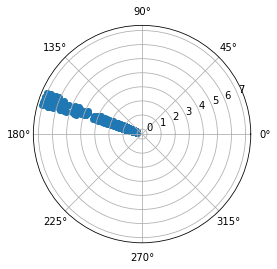

In [187]:
ax = plt.subplot(111, polar=True)
ax.scatter(x=np.deg2rad(data["ra"]), y=data["Spec_redshift"])

<AxesSubplot:xlabel='Spec_redshift', ylabel='Count'>

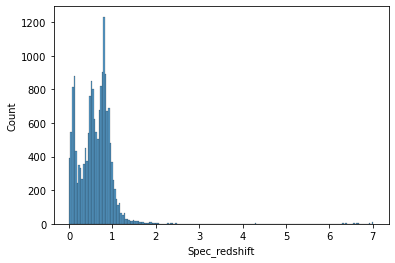

In [188]:
sns.histplot(data, x="Spec_redshift")

## Distance ladder
Equation (4.2.2) of Coles & Lucchin (p.77) comes essentially from the Hubble law
$$
d \simeq \frac{c}{H_0}z \simeq 3000h^{-1} z \,\, \text{Mpc}
$$

Some comments about its validity:

* d must be sufficiently large that the recession velocity $v = H_0 d$ is much larger than the peculiar velocity of the object. In terms of redshift, this means $z \gg 10^{-2}$
* The velocity must not be so large that v is greater than the speed of light. Then, $z \ll 10^{-1}$

These conditions together means that $10^{-2} \leq z \leq 10^{-1}$

In a Friedmann model, this result is an approximation. Indeed,
$$
    a(t) = a_0 \left(1 + H_0(t - t_0) - \frac{1}{2}q_0 H_0^2 (t - t_0)^2 + \dots \right)
$$
where $q_0$ is the deceleration parameter
$$
    q_0 = \frac{\ddot{a}(t_0) a_0}{\dot{a}(t_0)^2}
$$

Redshift is defined as 
$$
    1 + z = \frac{a_0}{a} = \frac{\lambda_{\text{obs}}}{\lambda_{\text{source}}}
$$
this means that
$$
    z = H_0 (t_0 - t) + \left(1 + \frac{1}{2}q_0\right)H_0^2(t_0 - t)^2 + \dots 
$$

To find the distance $r$, we need to use the FRW metric,
$$
    \int_t^{t_0} \frac{c dt}{a} = \int_0^r \frac{dr}{(1 - \kappa r^2)^{1/2}} 
$$

Therefore
$$
    \frac{c}{a_0} \int_t^{t_0} [1 + H_0 (t_0 - t) + \left(1 + \frac{1}{2}q_0\right)H_0^2(t_0 - t)^2 + \dots ] \simeq r + \mathcal{O}(r^3)
$$
The distance can therefore be expressed in term of the redshift
$$
    r = \frac{c}{a_0H_0}[z - \frac{1}{2}(1 + q_0)z^2 + \dots] 
$$
by inverting the series.

The luminosity distance can be derived so that the radiative inverse square law of propagation is respected:
$$
    d_L = a_0^2 \frac{r}{a}
$$
We can therefore show that
$$
    d_L = \frac{c}{H_0} [z + \frac{1}{2}(1 - q_0)z^2 + \dots]
$$

## Preprocessing


In [189]:
data = data[(data["Spec_redshift"] < 0.2) & (data["Spec_redshift"] > 0.001)]
# data = data[(data["Photo_redshift"] < 0.9) & (data["Photo_redshift"] > 0.2)]
data = data[data["class"] == "GALAXY"]

In [190]:
H0 = 72 * u.km / u.s / u.Mpc
alpha = (c/H0).to(u.Mpc)

In [191]:
# spherical coordinates
theta = np.deg2rad(data["dec"]).to_numpy()
phi = np.deg2rad(data["ra"]).to_numpy()
# r = alpha * data["Photo_redshift"].to_numpy()
r = alpha * data["Spec_redshift"].to_numpy()
#cartesian coordinates
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

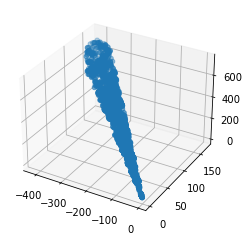

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

## Autocorrelation function 

In [198]:
# select a subsample to speed up computation during testing
select = 1
indices = np.random.randint(0, len(x), int(select * len(x)))
_x = x[indices].value # remove unit to speed up computation
_y = y[indices].value
_z = z[indices].value
position = np.concatenate([_x[:, np.newaxis], _y[:, np.newaxis], _z[:, np.newaxis]], axis=1)

In [199]:
# compute all distances between unique pairs
n = len(_x)
pairs = np.zeros(n * (n - 1)//2) #* u.Mpc
k = 0
# remove border effects -> there is too much pairs close to each other below 1000 Mpc
for i in range(n-1):
    for j in range(i+1, n):
        d = position[i] - position[j]
        pairs[k] = np.sqrt(np.dot(d, d))
        k += 1

In [200]:
stats.describe(pairs)

DescribeResult(nobs=4408965, minmax=(0.0, 823.4343106099267), mean=217.99220891003608, variance=23881.35182323492, skewness=0.7979537141615677, kurtosis=0.08013408077136841)

Text(0.5, 0, 'Distance (Mpc)')

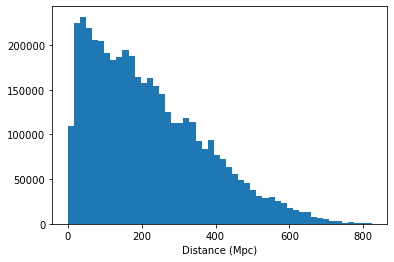

In [201]:
plt.hist(pairs, bins=50)
plt.xlabel("Distance (Mpc)")